### Домашнее задание №5 к лекции «Задачи классификации и кластеризации»

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import (accuracy_score, silhouette_score)

#### Задание.
1. Возьмите датасет с цветками iris’а (функция load_iris из библиотеки sklearn)  
2. Оставьте два признака - sepal_length и sepal_width и целевую переменную - variety
3. Разделите данные на выборку для обучения и тестирования
4. Постройте модель LDA
5. Визуализируйте предсказания для тестовой выборки и центры классов
6. Отбросьте целевую переменную и оставьте только два признака - sepal_length и sepal_width
7. Подберите оптимальное число кластеров для алгоритма kmeans и визуализируйте полученную кластеризацию

In [2]:
iris = load_iris(as_frame=True)

In [3]:
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['variety'] = iris.target

In [4]:
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),variety
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [5]:
df['variety'].value_counts()

0    50
1    50
2    50
Name: variety, dtype: int64

In [6]:
df_1 = df[['sepal length (cm)', 'sepal width (cm)', 'variety']]

In [7]:
def model(df, filtr=None):
    df = df[df['variety'] != filtr]
    X = df[['sepal length (cm)', 'sepal width (cm)']]
    y = df['variety']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train, y_train)
    y_pred = lda.predict(X_test)
    y_proba = lda.predict_proba(X_test)

    
    Accuracy = (accuracy_score(y_test, y_pred))
    print(f'Accuracy = {Accuracy:.2}')
    result = pd.DataFrame([np.array(y_test), y_pred], index=['test', 'pred']).T.head(20)
    display(result.T)
    
   
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 4))
    ax1.scatter(
    x = X_test['sepal length (cm)'],
    y = X_test['sepal width (cm)'], 
    c = y_pred)
    ax1.set_title('Предсказанные классы')
    ax1.scatter(lda.means_[:,0], lda.means_[:,1], c='r', s=100, marker='*')
    ax2.scatter(
    x = X_test['sepal length (cm)'],
    y = X_test['sepal width (cm)'], 
    c = y_test)
    ax2.set_title('Фактические классы')
    ax2.scatter(lda.means_[:,0], lda.means_[:,1], c='r', s=100, marker='*')    

Accuracy = 0.87


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
test,1,0,2,1,1,0,1,2,1,1,2,0,0,0,0,1,2,1,1,2
pred,1,0,2,1,2,0,1,2,1,1,2,0,0,0,0,2,2,1,1,2


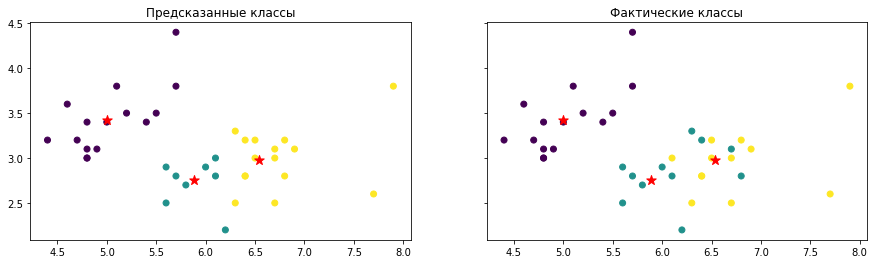

In [8]:
model(df_1)

__Accuracy__ - доля верно угаданных ответов из всех прогнозов. Чем ближе значение accuracy к 100%, тем лучше. В нашем случае 87% - значит хорошо

Сравнивая предсказанные значения классов и фактические, по первым 20 видно что модель предсказывает хорошо.
Сравнивая графики предсказанных классов с фактическими, создается впечатление что модель распределяет классы лучше чем в природе. Скорее всего это обусловлено тем что в жизни бывают отклонения, а модель ищет более общие закономерности.

In [9]:
X = df_1.drop(['variety'], axis = 1) 

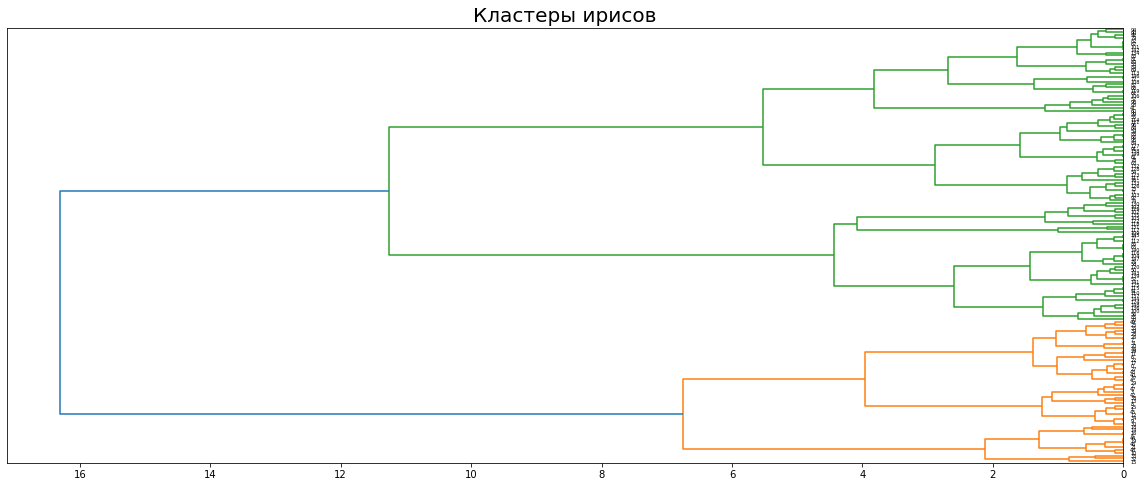

CPU times: user 1.13 s, sys: 48.6 ms, total: 1.18 s
Wall time: 447 ms


In [10]:
%%time
sc = StandardScaler()
X_sc = sc.fit_transform(X)
links = linkage(X_sc, method = 'ward')
plt.figure(figsize=(20, 8))
plt.title('Кластеры ирисов', size=20)
dendrogram(links, orientation='left')

plt.show()

2, silhouette - 0.448
3, silhouette - 0.434
4, silhouette - 0.418
5, silhouette - 0.401
6, silhouette - 0.383
7, silhouette - 0.401
8, silhouette - 0.410
9, silhouette - 0.431


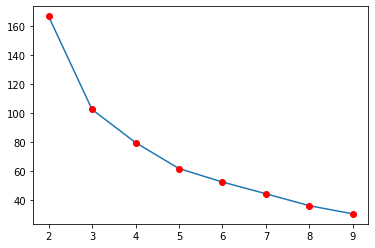

In [11]:
k_inertia = []
ks = range(2,10)
for k in ks:
    clf_kmeans = KMeans(n_clusters=k, random_state=0)
    clusters_kmeans = clf_kmeans.fit_predict(X_sc)
    k_inertia.append(clf_kmeans.inertia_)
    labels = clf_kmeans.fit_predict(X_sc)
    s_score = silhouette_score(X_sc, labels)
    print(f'{k}, silhouette - {s_score:.3f}')

plt.plot(ks, k_inertia)
plt.plot(ks, k_inertia, 'ro')
plt.show()


* Дендрограмма предлагает делить на __2 кластера__, 
* Метрика силуэта (_показывает, насколько объект своего кластера похож на свой кластер больше_) так же на __2 кластера__
* А вот метод локтя показывает плавное снижение без особых перегибов и вроде как делить на __3 кластера__
___
Поделим на несколько и сравним распределения

In [12]:
def clust(df_, n_clusters = 2):
    df = df_.copy()
    X = df.drop(['variety'], axis = 1) 
    sc = StandardScaler()
    X_sc = sc.fit_transform(X)
    km = KMeans(n_clusters = n_clusters, random_state=0)
    labels = km.fit_predict(X_sc)
    df['cluster'] = labels
    plt.scatter(x = X['sepal length (cm)'],y = X['sepal width (cm)'], 
    c = labels)
    plt.title(f'Количество кластеров - {n_clusters} ', size=13)

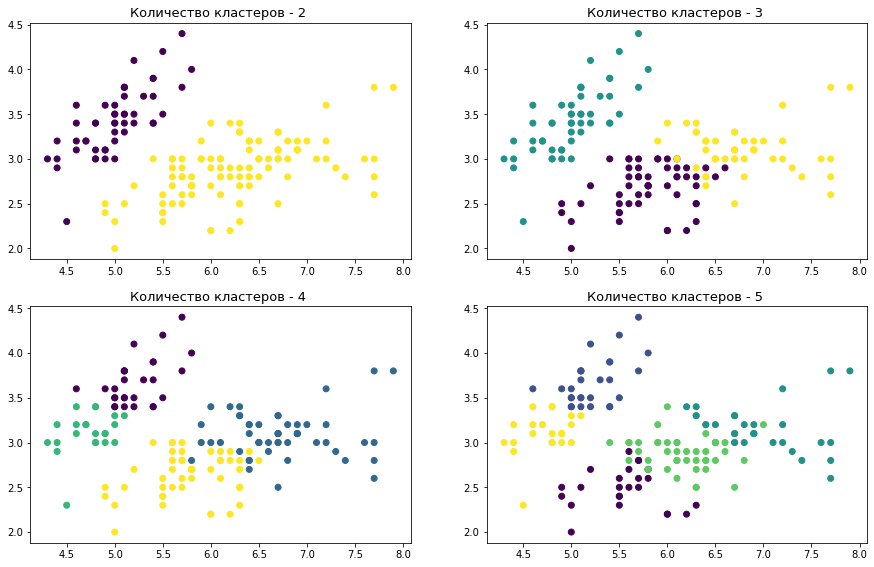

In [13]:
fig = plt.figure(figsize=(15,20))
for i in range(2, 6):
    fig.add_subplot(4, 2, i+1)
    clust(df, n_clusters = i)

* Заметно что при делении на 2 кластера видны 2 области (за исключением 1 фиолетовой точки с координатами (2.3, 4.5)
* При делении на 3 кластера все точки на своих местах, но между двумя нижними областями легкая диффузия. Все же верхнее поле отделено более очевидным образом
* При делении на 4 и 5 кластеров все вроде не так плохо, но это уже деление ради деления
___
__ОСТАВИМ ДВА КЛАССТЕРА__, все таки "пролив" между верхним и нижним полем выглядит убедительно